In [204]:
import networkx as nx
import pandas as pd
import ast
import matplotlib.pyplot as plt

## Recipe Graph

In [205]:
def create_recipe_ingredient_graphs(recipes_df, thresholds):
    if isinstance(recipes_df['ingredients'].iloc[0], str):
        recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)
    
    graphs = {min_common: nx.Graph() for min_common in thresholds}

    for _, row in recipes_df.iterrows():
        for min_common in thresholds:
            graphs[min_common].add_node(
                row['id'], 
                name=row['name'], 
                num_ingredients=len(row['ingredients']),
                ingredients=row['ingredients']
            )
    
    for i in range(len(recipes_df)):
        for j in range(i + 1, len(recipes_df)):
            ingredients1 = set(recipes_df['ingredients'].iloc[i])
            ingredients2 = set(recipes_df['ingredients'].iloc[j])
            common_ingredients = ingredients1.intersection(ingredients2)
            common_count = len(common_ingredients)
            
            for min_common in thresholds:
                if common_count >= min_common:
                    graphs[min_common].add_edge(
                        recipes_df['id'].iloc[i],
                        recipes_df['id'].iloc[j],
                        weight=common_count,
                        common_ingredients=list(common_ingredients)
                    )
    
    return graphs

In [206]:
def get_recipe_by_id(G, recipe_id):
    if recipe_id not in G.nodes():
        raise ValueError(f"Recipe ID {recipe_id} not found in the graph")
    
    node_data = G.nodes[recipe_id]
    return {
        'id': recipe_id,
        'name': node_data.get('name', 'Unknown'),
        'num_ingredients': node_data.get('num_ingredients', 0),
        'ingredients': node_data.get('ingredients', [])
    }


In [207]:
def find_most_connected_recipes(G, top_n=10):

    degrees = dict(G.degree())
    
    top_recipes = sorted(
        [(node, degree, G.nodes[node]['name']) for node, degree in degrees.items()], 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]
    
    return [
        {
            'id': recipe[0], 
            'connections': recipe[1], 
            'name': recipe[2]
        } 
        for recipe in top_recipes
    ]


In [208]:
def analyze_recipe_ingredient_graph(G):
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'density': nx.density(G),
        'connected_components': nx.number_connected_components(G)
    }

In [209]:
recipes_df = pd.read_csv(r'RAW_recipes.csv')

In [210]:
recipes_df.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


We choose to use the reipes that are big enough, meaning they have at least 6 ingredients, as recipes too small are not relevant for us.

In [211]:
import ast
recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)

In [212]:
recipes_df = recipes_df[recipes_df['ingredients'].apply(len) >= 6]

In [213]:
unique_ingredients = set()
for ingredients_list in recipes_df['ingredients']:
    unique_ingredients.update(ingredients_list)

num_unique_ingredients = len(unique_ingredients)

print(f'Number of unique ingredients: {num_unique_ingredients}')


Number of unique ingredients: 14001


In [214]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [215]:
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"[celery, onion, green sweet pepper, garlic clo...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"[paprika, salt, garlic powder, onion powder, d...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","[hard-cooked eggs, mayonnaise, dijon mustard, ...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","[butter, eagle brand condensed milk, light bro...",10


As we can see, we still have too many recipes, and we don't have enogh computational power to construct such a graph that has 190.000 nodes. That is why we decided to filter for the recipes which have newer uploading date.

In [216]:
recipes_df['submitted'] = pd.to_datetime(recipes_df['submitted'], errors='coerce')

In [217]:
min_date = recipes_df['submitted'].min()
max_date = recipes_df['submitted'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 1999-08-06 00:00:00
Maximum date: 2018-12-04 00:00:00


In [218]:
recipes_df = recipes_df[recipes_df['submitted'] > '2013-12-31']

In [219]:
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
136,lplermagrone,522861,50,135470,2015-07-25,"['60-minutes-or-less', 'time-to-make', 'course...","[1003.8, 72.0, 21.0, 103.0, 69.0, 143.0, 37.0]",10,['a variant on the theme: in the swiss canton ...,älplermagronethe name doesn't translate perfec...,"[milk, salt, macaroni, cheese, fresh coarse gr...",8
142,der wiener schnitzel style chili dog sauce,523359,55,2000414501,2015-08-27,"['60-minutes-or-less', 'time-to-make', 'prepar...","[259.7, 23.0, 18.0, 31.0, 34.0, 28.0, 4.0]",16,['in a large size dutch oven or large size dee...,this was the best chili dog ever invented! i l...,"[ground beef, ground pork, water, cornstarch, ...",14
329,better than a can homemade sloppy joes,513531,50,1783373,2014-02-21,"['weeknight', '60-minutes-or-less', 'time-to-m...","[291.5, 13.0, 85.0, 25.0, 13.0, 7.0, 16.0]",26,['to start the sauce: heat a 2 1 / 2-quart non...,i've had this recipe for many years and i used...,"[olive oil, yellow onion, green bell pepper, r...",18
337,buffalo wing mushrooms,535020,30,33186,2018-01-29,"['30-minutes-or-less', 'time-to-make', 'course...","[2526.8, 345.0, 35.0, 106.0, 43.0, 87.0, 37.0]",8,"['in a medium-large mixing bowl , add in panko...",courtesy of ps kitchen.,"[mushrooms, cornstarch, all-purpose flour, sal...",8
369,dorito popcorn seasoning,519068,5,336058,2014-10-17,"['15-minutes-or-less', 'time-to-make', 'course...","[785.7, 29.0, 11.0, 788.0, 169.0, 12.0, 36.0]",3,['combine all seasonings and blend in a coffee...,this is quick and easy. from the blog www.who...,"[nutritional yeast, garlic powder, onion powde...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231176,zucchini fritters low carb,522243,25,46273230,2015-06-01,"['30-minutes-or-less', 'time-to-make', 'course...","[140.3, 18.0, 7.0, 17.0, 10.0, 24.0, 1.0]",16,"['shred or grate zucchini', 'using fine sieve ...",this is an excellent side dish for summer meal...,"[zucchini, scallions, eggs, cream cheese, parm...",12
231221,zucchini lemon poppyseed bread,517690,80,508997,2014-08-04,"['time-to-make', 'course', 'preparation', 'occ...","[2144.9, 110.0, 825.0, 64.0, 75.0, 59.0, 116.0]",9,"['preheat oven to 375 degrees', 'in a medium b...",i wanted to try something a little different w...,"[sugar, eggs, vanilla, vegetable oil, milk, le...",14
231410,zucchini tater tots,528086,50,2000228837,2016-08-31,"['60-minutes-or-less', 'time-to-make', 'course...","[38.2, 3.0, 2.0, 6.0, 5.0, 5.0, 0.0]",12,"['preheat oven to 400f', 'place the grated zuc...",these tots are a healthy twist on classic tate...,"[zucchini, shallots, mozzarella cheese, parmes...",11
231481,zucchini kale and tomato saute,515473,25,287945,2014-04-16,"['30-minutes-or-less', 'time-to-make', 'course...","[101.0, 5.0, 24.0, 9.0, 9.0, 2.0, 5.0]",4,"['heat oil in large skillet over medium heat ,...",this is a good way to use up kale and zucchini...,"[extra virgin olive oil, onion, garlic cloves,...",10


In [220]:
mapping_df = pd.read_excel('ingredients.xlsx')

In [221]:
mapping_df

,raw_ingr,extracted_ingredient
0,fuyu persimmons,persimmon
1,whole crisp corn tortillas,corn
2,cilantro paste,cilantro
3,gluten-free oats,oats
4,white chocolate wafers,white chocolate
...,...,...
14937,beans and carrots vegetable mix,beans
14938,dry whole grain breadcrumbs,breadcrumb
14939,golden delicious apples,apple
14940,stewed tomatoes with herbs,tomato


In [222]:
ingredient_mapping = dict(zip(mapping_df['raw_ingr'], mapping_df['extracted_ingredient']))

def replace_ingredients(ingredient_list):
    return [ingredient_mapping.get(ingr, ingr) for ingr in ingredient_list]

recipes_df['ingredients'] = recipes_df['ingredients'].apply(replace_ingredients)


/var/folders/2j/w5gyp6sx2xqdbzcqb6l19dvr0000gn/T/ipykernel_68005/1019937175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_df['ingredients'] = recipes_df['ingredients'].apply(replace_ingredients)


In [223]:
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
136,lplermagrone,522861,50,135470,2015-07-25,"['60-minutes-or-less', 'time-to-make', 'course...","[1003.8, 72.0, 21.0, 103.0, 69.0, 143.0, 37.0]",10,['a variant on the theme: in the swiss canton ...,älplermagronethe name doesn't translate perfec...,"[Milk, salt, macaroni, cheese, pepper, butter,...",8
142,der wiener schnitzel style chili dog sauce,523359,55,2000414501,2015-08-27,"['60-minutes-or-less', 'time-to-make', 'prepar...","[259.7, 23.0, 18.0, 31.0, 34.0, 28.0, 4.0]",16,['in a large size dutch oven or large size dee...,this was the best chili dog ever invented! i l...,"[beef, pork, water, cornstarch, flour, tomato,...",14
329,better than a can homemade sloppy joes,513531,50,1783373,2014-02-21,"['weeknight', '60-minutes-or-less', 'time-to-m...","[291.5, 13.0, 85.0, 25.0, 13.0, 7.0, 16.0]",26,['to start the sauce: heat a 2 1 / 2-quart non...,i've had this recipe for many years and i used...,"[olive oil, onion, pepper, pepper, celery, gar...",18
337,buffalo wing mushrooms,535020,30,33186,2018-01-29,"['30-minutes-or-less', 'time-to-make', 'course...","[2526.8, 345.0, 35.0, 106.0, 43.0, 87.0, 37.0]",8,"['in a medium-large mixing bowl , add in panko...",courtesy of ps kitchen.,"[mushroom, cornstarch, flour, salt, pepper, se...",8
369,dorito popcorn seasoning,519068,5,336058,2014-10-17,"['15-minutes-or-less', 'time-to-make', 'course...","[785.7, 29.0, 11.0, 788.0, 169.0, 12.0, 36.0]",3,['combine all seasonings and blend in a coffee...,this is quick and easy. from the blog www.who...,"[yeast, garlic, onion, cumin, Paprika, chili, ...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231176,zucchini fritters low carb,522243,25,46273230,2015-06-01,"['30-minutes-or-less', 'time-to-make', 'course...","[140.3, 18.0, 7.0, 17.0, 10.0, 24.0, 1.0]",16,"['shred or grate zucchini', 'using fine sieve ...",this is an excellent side dish for summer meal...,"[zucchini, scallion, eggs, cream cheese, parme...",12
231221,zucchini lemon poppyseed bread,517690,80,508997,2014-08-04,"['time-to-make', 'course', 'preparation', 'occ...","[2144.9, 110.0, 825.0, 64.0, 75.0, 59.0, 116.0]",9,"['preheat oven to 375 degrees', 'in a medium b...",i wanted to try something a little different w...,"[sugar, eggs, vanilla, oil, Milk, lemon, salt,...",14
231410,zucchini tater tots,528086,50,2000228837,2016-08-31,"['60-minutes-or-less', 'time-to-make', 'course...","[38.2, 3.0, 2.0, 6.0, 5.0, 5.0, 0.0]",12,"['preheat oven to 400f', 'place the grated zuc...",these tots are a healthy twist on classic tate...,"[zucchini, shallot, mozzarella, parmesan, pank...",11
231481,zucchini kale and tomato saute,515473,25,287945,2014-04-16,"['30-minutes-or-less', 'time-to-make', 'course...","[101.0, 5.0, 24.0, 9.0, 9.0, 2.0, 5.0]",4,"['heat oil in large skillet over medium heat ,...",this is a good way to use up kale and zucchini...,"[olive oil, onion, garlic, zucchini, tomatoes,...",10


In [224]:
def generate_and_save_graphs_optimized(recipes_df, thresholds):
    graphs = create_recipe_ingredient_graphs(recipes_df, thresholds)
    
    for min_common, graph in graphs.items():
        file_name = f"final_recipe_graph_min_common_{min_common}.gml"
        nx.write_gml(graph, file_name)
        print(f"Graph with min_common_ingredients={min_common} saved to {file_name}")

In [225]:
thresholds = [3, 5, 6]
generate_and_save_graphs_optimized(recipes_df, thresholds)

Graph with min_common_ingredients=3 saved to final_recipe_graph_min_common_3.gml
Graph with min_common_ingredients=5 saved to final_recipe_graph_min_common_5.gml
Graph with min_common_ingredients=6 saved to final_recipe_graph_min_common_6.gml


In [226]:
G_3_ingredients = nx.read_gml("final_recipe_graph_min_common_3.gml")

In [227]:
def visualize_graph(G, top_n=100, label_threshold=None):

    degrees = dict(G.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    
    H = G.subgraph(top_nodes)
    
    if label_threshold is None:
        sorted_degrees = sorted(degrees.values(), reverse=True)
        label_threshold = sorted_degrees[min(int(top_n * 0.2), len(sorted_degrees)-1)]
    
    plt.figure(figsize=(24,24))
    
    pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)
    
    node_sizes = [degrees[node]*20 for node in H.nodes()]
    node_colors = ['lightblue' if degrees[node] < label_threshold else 'salmon' for node in H.nodes()]
    
    nx.draw_networkx_nodes(H, pos, 
                            node_color=node_colors, 
                            node_size=node_sizes)
    
    nx.draw_networkx_edges(H, pos, 
                            width=0.3, 
                            alpha=0.5)
    
    labels = {
        node: G.nodes[node]['name'] 
        for node in H.nodes() 
        if degrees[node] >= label_threshold
    }
    nx.draw_networkx_labels(H, pos, 
                             labels, 
                             font_size=8, 
                             font_weight="bold")
    
    plt.title(f"Recipe Ingredient Graph - Top {top_n} Nodes (Labeled Nodes with Degree ≥ {label_threshold})")
    plt.axis('off')
    
    return plt.gcf()

/var/folders/2j/w5gyp6sx2xqdbzcqb6l19dvr0000gn/T/ipykernel_68005/2118438273.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualize_graph(G_3_ingredients).show()


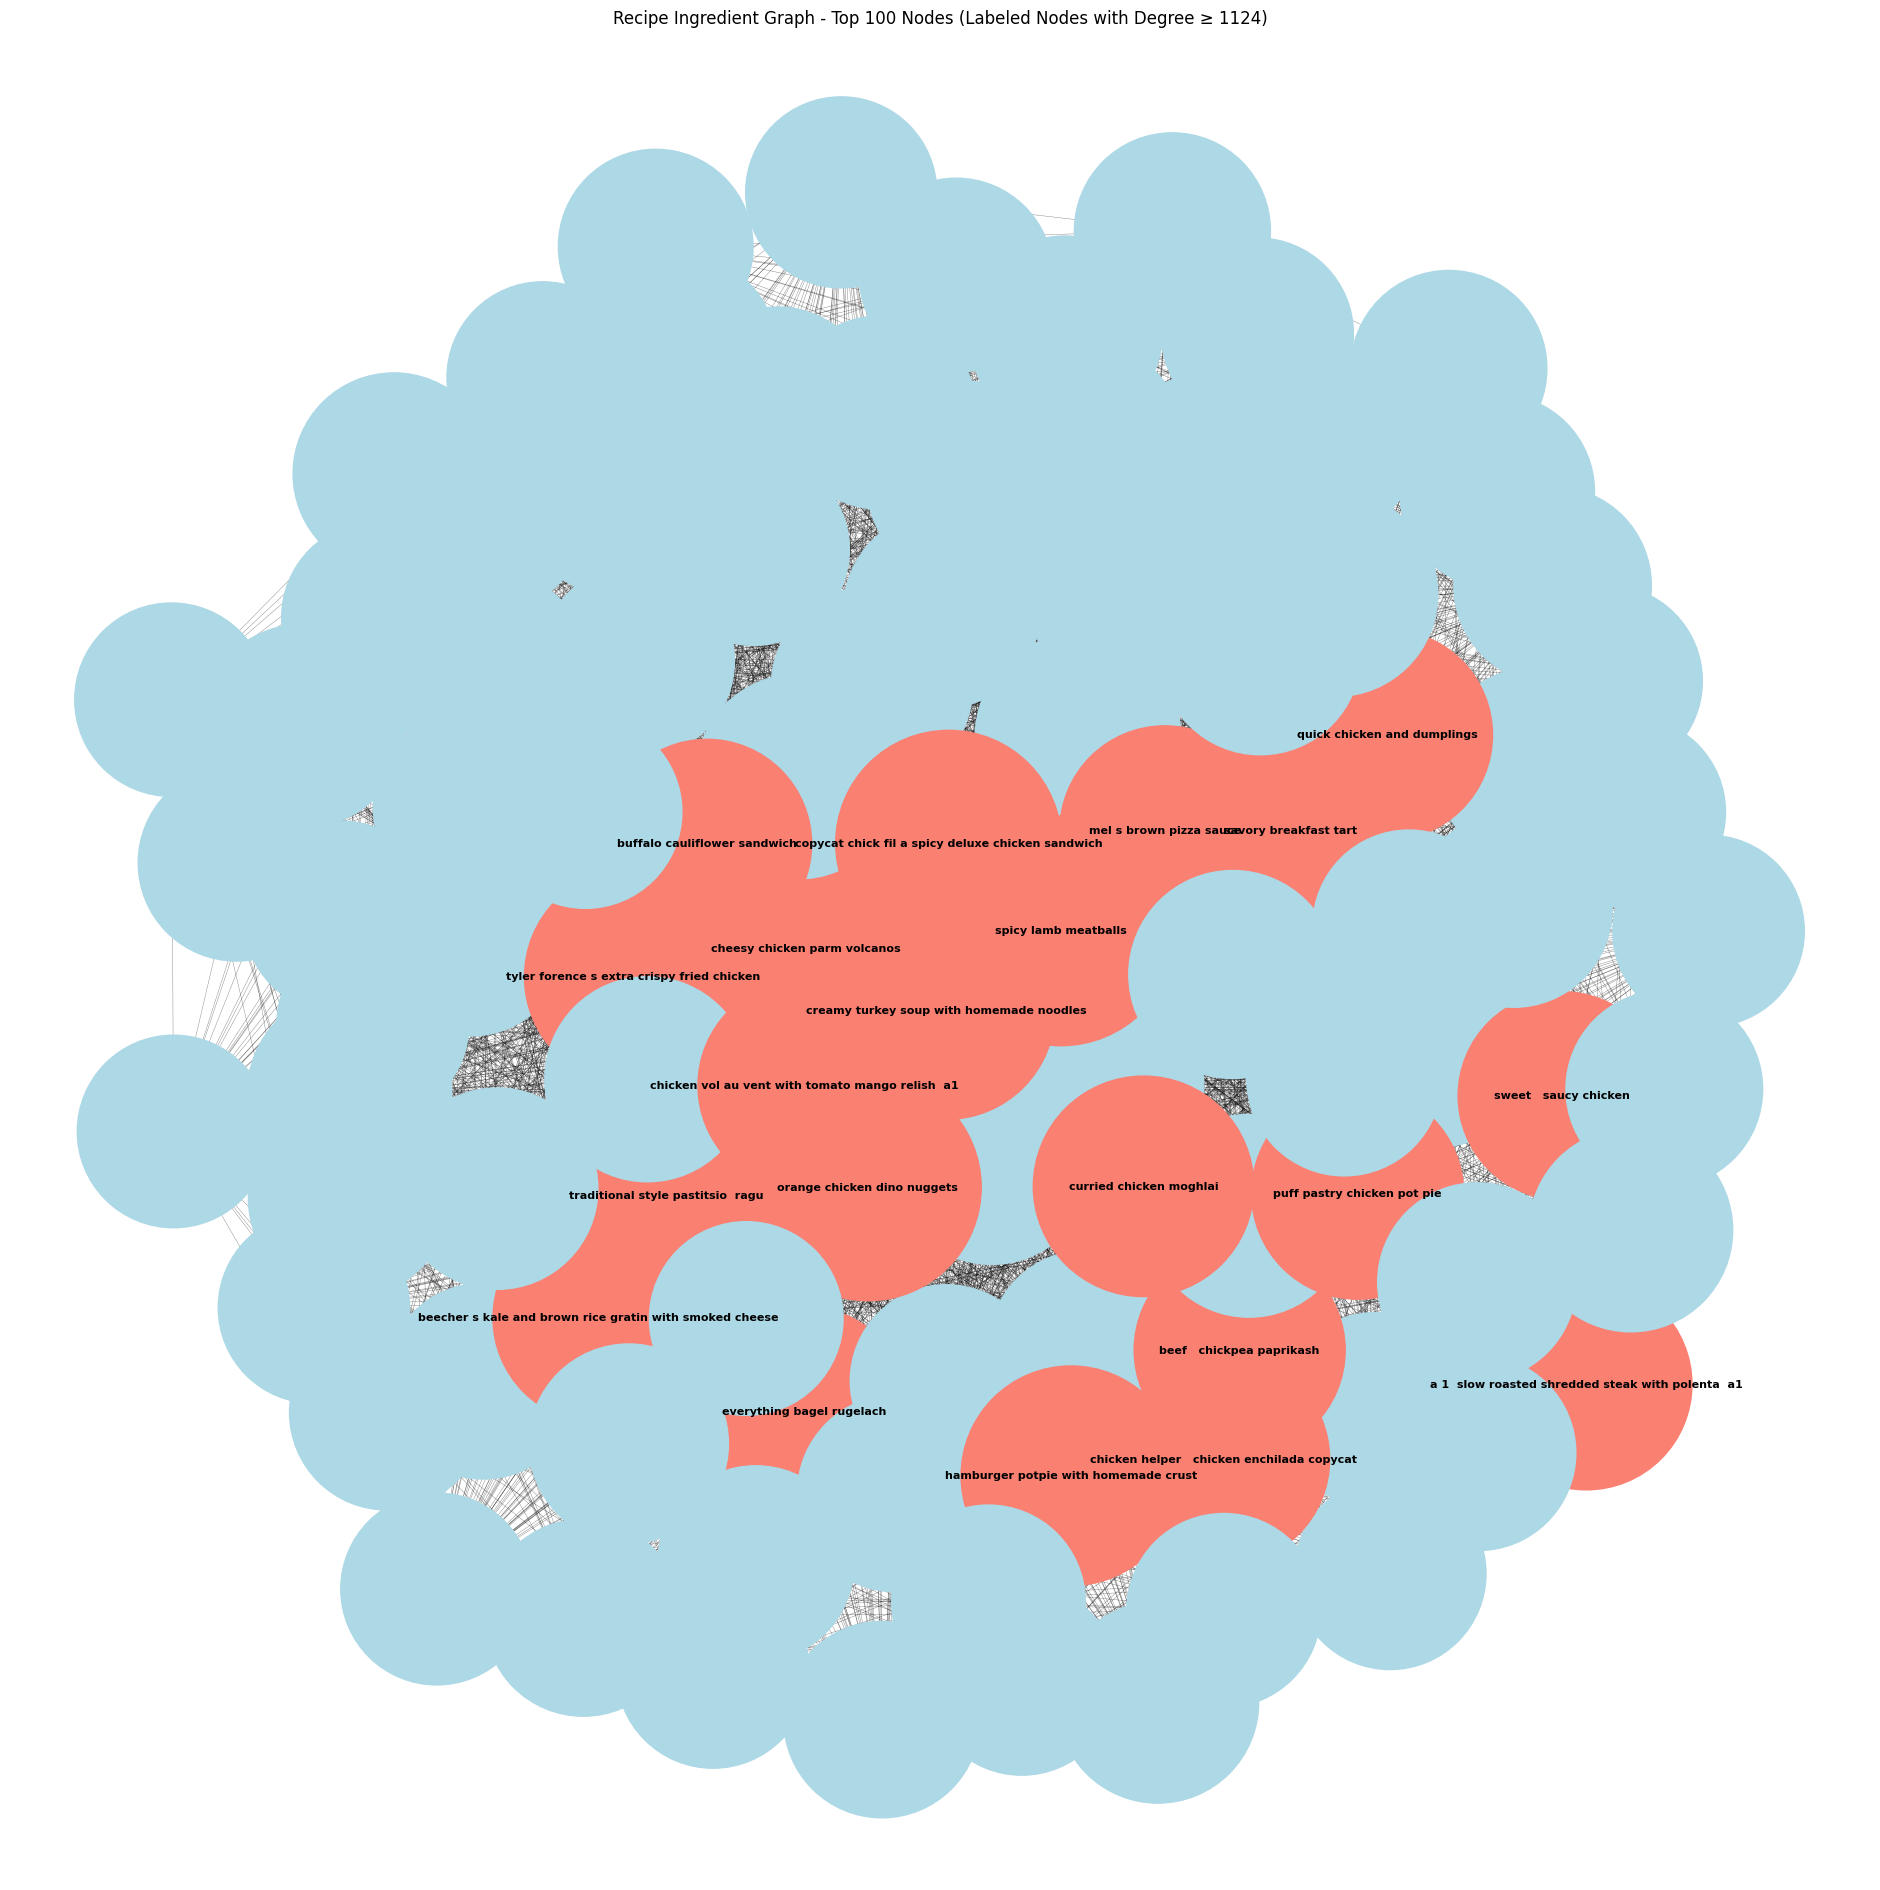

In [228]:
visualize_graph(G_3_ingredients).show()